In [1]:
import numpy as np
import skimage
from skimage import data, segmentation, color, util, filters
from skimage import io
from skimage.filters import unsharp_mask
from skimage.measure import label
from skimage.measure import regionprops
from skimage.morphology import remove_small_objects
from matplotlib import pyplot as plt
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cProfile


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

def segment_image(img, scale=500, sigma=0.5, min_size=50):
    
    segments = skimage.segmentation.felzenszwalb(img, scale=scale, sigma=sigma, min_size=min_size)

    labeled_segments = label(segments)
    cleaned_segments = remove_small_objects(labeled_segments, min_size=min_size)

    return cleaned_segments


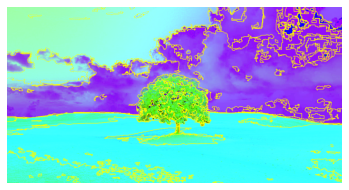

In [3]:
def enhance_edges(img, radius=2, amount=1):

    return unsharp_mask(img, radius=radius, amount=amount)

def convert_color_space(img, space='RGB'):

    if space == 'HSV':
        return color.rgb2hsv(img)
    elif space == 'Lab':
        return color.rgb2lab(img)
    else:
        return img

img = io.imread('img.jpg')  

enhanced_img = enhance_edges(img)
converted_img = convert_color_space(enhanced_img, space='HSV')


segmented_image = segment_image(converted_img, scale=500, sigma=0.5, min_size=50)

plt.figure(figsize=(6, 6))
plt.imshow(segmentation.mark_boundaries(converted_img, segmented_image))
plt.axis('off')
plt.show()


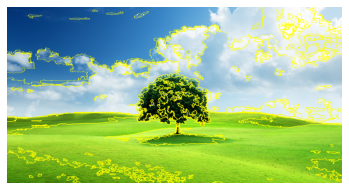

In [4]:
def calculate_region_similarity(region1, region2):

    
    color_diff = np.linalg.norm(region1.mean_intensity - region2.mean_intensity)
    return color_diff

def merge_similar_regions(labels, threshold=15):

    regions = regionprops(labels, intensity_image=segmented_image)
    
    similar_regions = []
    for i, region1 in enumerate(regions):
        for j, region2 in enumerate(regions[i+1:], i+1):
            if calculate_region_similarity(region1, region2) < threshold:
                similar_regions.append((i, j))

    for i, j in similar_regions:
        labels[labels == j] = i

    return labels

merged_labels = merge_similar_regions(segmented_image)

plt.figure(figsize=(6, 6))
plt.imshow(segmentation.mark_boundaries(img, merged_labels))
plt.axis('off')
plt.show()


In [5]:

import unittest
from skimage.metrics import structural_similarity as ssim

class TestSegmentation(unittest.TestCase):
    def test_segmentation_output(self):
        pass

    def test_similarity_with_ground_truth(self):
        pass


In [6]:

import tensorflow as tf
from tensorflow.keras.models import load_model


def preprocess_image_for_model(img):

    return img


def segment_with_ml_model(img):

    preprocessed_img = preprocess_image_for_model(img)
    segmentation_result = model.predict(preprocessed_img)
    return segmented_img



2024-01-19 15:01:13.984288: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 15:01:13.985740: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 15:01:14.022103: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 15:01:15.745376: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:

import tkinter as tk
from tkinter import filedialog, Scale, Label, Canvas
from PIL import Image, ImageTk
import numpy as np
from skimage import io, segmentation, color
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

root = tk.Tk()
root.title("Enhanced Image Segmentation Tool")

current_image = None
current_segmentation = None
canvas_original = None
canvas_segmented = None
roi = None

def load_image():
    global current_image, canvas_original, canvas_segmented
    file_path = filedialog.askopenfilename()
    if file_path:
        img = io.imread(file_path)
        current_image = img
        if canvas_original:
            canvas_original.get_tk_widget().pack_forget()
        if canvas_segmented:
            canvas_segmented.get_tk_widget().pack_forget()
        fig_original = Figure(figsize=(5, 4), dpi=100)
        fig_original.add_subplot(111).imshow(img)
        fig_original.subplots_adjust(left=0,right=1,top=1,bottom=0)
        canvas_original = FigureCanvasTkAgg(fig_original, master=root)
        canvas_original.draw()
        canvas_original.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=1)
        
        canvas_original.get_tk_widget().bind("<Button-1>", on_canvas_click)
        
        fig_segmented = Figure(figsize=(5, 4), dpi=100)
        fig_segmented.add_subplot(111).text(0.5, 0.5, 'Segmented image will appear here.', 
                                            horizontalalignment='center', verticalalignment='center')
        fig_segmented.subplots_adjust(left=0,right=1,top=1,bottom=0)
        canvas_segmented = FigureCanvasTkAgg(fig_segmented, master=root)
        canvas_segmented.draw()
        canvas_segmented.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH, expand=1)
        update_segmentation()

def update_segmentation():
    global current_image, current_segmentation, canvas_segmented, roi
    if current_image is not None:
        scale_val = scale_slider.get()
        sigma_val = sigma_slider.get() / 10
        min_size_val = min_size_slider.get()
        segmented_image = segment_image(current_image, scale=scale_val, sigma=sigma_val, min_size=min_size_val)
        current_segmentation = segmented_image
        
        marked_image = segmentation.mark_boundaries(current_image, segmented_image)
        if roi:
            marked_image = marked_image[roi[1]:roi[3], roi[0]:roi[2]]
        if canvas_segmented:
            canvas_segmented.get_tk_widget().pack_forget()
        fig_segmented = Figure(figsize=(5, 4), dpi=100)
        fig_segmented.add_subplot(111).imshow(marked_image)
        fig_segmented.subplots_adjust(left=0,right=1,top=1,bottom=0)
        canvas_segmented = FigureCanvasTkAgg(fig_segmented, master=root)
        canvas_segmented.draw()
        canvas_segmented.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH, expand=1)

        
        
def on_canvas_click(event):
    global roi
    
    roi = (event.x, event.y, event.x + 100, event.y + 100) 
    update_segmentation()

load_button = tk.Button(root, text="Load Image", command=load_image)
load_button.pack()

scale_slider = Scale(root, from_=0, to=1000, orient='horizontal', label='Scale', length=300)
scale_slider.set(200)  
scale_slider.pack()

sigma_slider = Scale(root, from_=1, to=100, orient='horizontal', label='Sigma (x 0.1)', length=300)
sigma_slider.set(65)  
sigma_slider.pack()

min_size_slider = Scale(root, from_=0, to=200, orient='horizontal', label='Min Size', length=300)
min_size_slider.set(120)  
min_size_slider.pack()

update_button = tk.Button(root, text="Update Segmentation", command=update_segmentation)
update_button.pack()

root.mainloop()
